<a href="https://colab.research.google.com/github/google/jax-md/blob/periodic_general_refactor/notebooks/meta_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [3]:
from tqdm import tqdm
import time 
import colorsys
from functools import partial
from typing import Callable, List

import scipy

import numpy as onp
import jax.numpy as jnp
import jax
# from jax.experimental import stax
# from jax.experimental import optimizers
from jax.config import config
config.update('jax_enable_x64', True)
import jax_md
f32, f64 = jax_md.util.f32, jax_md.util.f64
#from jax_md import space
#from jax_md import minimize
# from jax_md import simulate
#from jax_md import energy
#from jax_md import quantity
#from jax_md.util import f32, f64

# Matplotlib settings.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='white')
sns.set(font_scale=1.6)

In [4]:
dir(jax.random)
jax.random.normal
jax.ops.index?

Type:        _Indexable
String form: <jax._src.ops.scatter._Indexable object at 0x7f052c9b9be0>
File:        ~/fun/simulation/simz/lib/python3.8/site-packages/jax-0.2.14-py3.8.egg/jax/_src/ops/scatter.py
Docstring:  
Helper object for building indexes for indexed update functions.

This is a singleton object that overrides the :code:`__getitem__` method
to return the index it is passed.

>>> jax.ops.index[1:2, 3, None, ..., ::2]
(slice(1, 2, None), 3, None, Ellipsis, slice(None, None, 2))


## Optimization Through Dynamics

Combining molecular dynamics with automatic differentiation opens the door for qualitatively new research. One such avenue involves differentiating through the simulation trajectory to optimize physical parameters. There have been several excellent applications so far in e.g. [protein folding](https://openreview.net/forum?id=Byg3y3C9Km), but until now this has involved significant amounts of specialized code. This vein of research is also similar to recent work in machine learning on [meta-optimization.](https://arxiv.org/abs/1606.04474) 

As an example we will perform optimize the parameters of a simple system to show that one can optimize for particular structural characteristics. In particular, we will imagine bubbles floating on water so that the bubbles live on a two-dimensional interface between water and air. It turns out that if the bubbles all have the same size and they are compressed then they form a crystal. Here's an example of a real experiment from [Wikipedia](https://en.wikipedia.org/wiki/Bubble_raft):

![alt text](https://upload.wikimedia.org/wikipedia/commons/8/89/Bubblerraft2.jpg)

However, if the bubbles have have different sizes, the crystal order breaks down and the system becomes random.

<img src="https://physicstoday.scitation.org/action/showOpenGraphArticleImage?doi=10.1063/PT.3.4243&id=images/medium/pt.3.4243.figures.online.pt.3.4243highlight.jpg" width="400">

We will show how one can control the structure of the bubble raft by differentiating through the simulation to tune how homogeneous or inhomogeneous the bubble sizes are. To experiment with these changes, we're going to set up a simulation of a bubble raft with bubbles of two distinct sizes. To keep things simple, we'll let half of the bubbles have diameter $1$ and half have diameter $D$. 

To control the conditions of the experiment, we will keep the total volume of the bubbles constant. To do this, note that if there are $N$ bubbles then the total volume of water filled by bubbles is,
$$V_{\text{bubbles}} = \frac N8\pi(D^2 + 1)$$
where the factor of $8$ comes from the fact that our system is split into two halves and we are using diameters not radii. Since the volume of our simulation is $V = L^2$ if we want to keep the "packing fraction", $\phi = V_{\text{bubbles}} / V$ constant then we will have to scale the size of the box to be,
$$L = \sqrt{\frac{V_{\text{bubbles}}}{\phi}}.$$
We begin by setting up some experiment parameters and writing a function to compute $L$ as a function of $D$.

In [5]:
# helper print function
def print_attrs(objs: List, attrs:  List[str] = ["shape"], info: str = "shapes"):
    sep = "=" * 20
    print(sep)
    info = info + ":" if not info.endswith(":") else info
    print(info)
    print([[getattr(obj, attr) for attr in attrs] for obj in objs])
    print(sep)

In [6]:
class JaxLife:
    # still kept as class so I dont have to unindent and refactor which is tedious in notebook;
    # but pay close attention not to actually read/write to external variables (e.g. the JaxLife's instance attributes)
    # within this object's methods !!! 
    # !!! See: !!! 
    # https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
    
    KEY = jax.random.PRNGKey(1337)

    @staticmethod
    def block_matrix(key, p0, p_std, num_species, particles_per_species, positive=False):
        """
        generates block matrix
        (used for assigning parameters to num_species * pps particles)
        """
        m = jax.random.normal(key, (num_species, num_species)) * p_std + p0
        m = m.repeat(particles_per_species,axis=1).repeat(particles_per_species,axis=0)
        # m: nsp * pps x nsp * pps

        if positive:
            return jnp.abs(m)
        else:
            return m
        
    def init_species(
            key,
            interaction_radius, separation_radius, force_strength, repelling_force, 
            stdev,
            num_species, particles_per_species,
        ):

        # parameter matrices
        force_radius = JaxLife.block_matrix(
            key, interaction_radius, interaction_radius * stdev, num_species, particles_per_species, positive=True
        )
        separation = JaxLife.block_matrix(
            key, separation_radius, separation_radius * stdev, num_species, particles_per_species, positive=True
        )
        forces = JaxLife.block_matrix(
            key, 0, force_strength, num_species, particles_per_species, positive=False
        )
        rep_force = JaxLife.block_matrix(
            key, repelling_force, repelling_force * stdev, num_species, particles_per_species, positive=True
        )

        # species properties
        species, colors, sizes, markers = [], [],[],[]
        num_pps = particles_per_species
        for s in range(num_species):
            """
            # Alternative features for species color:
            sep = jnp.abs(separation[0,s*num_pps])/jnp.max(separation)
            rep = jnp.abs(rep_force[0,s*num_pps])/jnp.max(rep_force)
            """
            #fs = jnp.abs(forces[0,s*num_pps])/jnp.max(jnp.abs(forces))
            #fd = jnp.abs(forces[s*num_pps, s*num_pps])/jnp.max(jnp.abs(forces))
            #fr = jnp.abs(force_radius[0,s*num_pps])/jnp.max(force_radius)
            
            #size = 20 + 50 * fs

            #fc = (forces[0, s*num_pps] - jnp.min(forces)) / (jnp.max(forces) - jnp.min(forces))

            #color = colorsys.hsv_to_rgb(fc,0.3+0.7*fd,0.5*(1+fs))
            for p in range(num_pps):
                species.append(s)
                #colors.append(color)
                #sizes.append(size)
                #markers.append(2*fr*15*size)

        species = jnp.array(species,dtype=jnp.int32)

        return force_radius, separation, forces, rep_force, species #, \
            #colors, sizes, markers

    @staticmethod
    def attract(
            R,
            displacement,
            width, height,
            total_particles,
            separation, force_radius,
            rep_force, forces,
            close_range_factor,
            dist_range_factor
        ):
        """
        calculate attractive forces between particles
        """
        
        """
        from https://github.com/google/jax-md/blob/f99f5f3c89d52890512e681b24c12cc9682ef1cc/jax_md/smap.py#L237
        # Each application of vmap adds a single batch dimension. For computations
        # over all pairs of particles, we would like to promote the metric function
        # from one that computes the displacement / distance between two vectors to
        # one that acts over the cartesian product of two sets of vectors. This is
        # equivalent to two applications of vmap adding one batch dimension for the
        # first set and then one for the second.
        """
        
        # dx = jnp.reshape(x, (total_particles, 1)) - x # x distance of each particle to all other particles
        # dy = jnp.reshape(y, (total_particles, 1)) - y
        dr = displacement(R, R)
        r = jnp.sqrt(jnp.sum(dr**2, axis=-1))
        # dx, dy = JaxLife.bound(dx, dy, width, height) # wrap borders
        
        #  -------- calculate sum of forces acting on each particle ----------

        # init sum of forces
        f = jnp.zeros((total_particles, total_particles))
        print("shapes:")
        arrs = [r, separation, f]
        print([arr.shape for arr in arrs])

        # i0 = jax.ops.index[jnp.where(r < separation)]
        i0 = r < separation
        i1 = ((r > separation) & (r < (separation + force_radius/2)))
        i2 = (r > separation + force_radius/2) & (r < separation + force_radius)

        # repellent close range force
        repellent_close_range_f = jnp.where(i0, rep_force, 0) * (jnp.where(i0, separation, 0) - jnp.where(i0, r, 0))
        f = jnp.where(i0, repellent_close_range_f,    f)
        # inner ring dr from separation to half force radius
        inner_ring_attractive_f = jnp.where(i1, forces, 0) * (jnp.where(i1, r, 0) - jnp.where(i1, separation, 0))
        f = jnp.where(i1, inner_ring_attractive_f,    f)
        # outer ring dr from half to full force radius
        outer_ring_repulsive_force = jnp.where(i2, -forces, 0) * (jnp.where(i2, r, 0) - (jnp.where(i2, separation, 0) + jnp.where(i2, force_radius, 0)))
        f = jnp.where(i2, outer_ring_repulsive_force, f)
        
        for i in range(f.shape[0]):
            f = jax.ops.index_update(f, jax.ops.index[i,i], 0) # no self-force

        # increase force at long range
        F = f * (close_range_factor + (dist_range_factor - close_range_factor) * (r/height))

        dx, dy = jnp.transpose(R)
        a = jnp.arctan2(dy,dx)

        # add contributions from all particles
        fx = jnp.sum(F * jnp.cos(a), axis=0)
        fy = jnp.sum(F * jnp.sin(a), axis=0)
        
        print("fx shape:", fx.shape, "fy shape:", fy.shape)
        return fx, fy

    @staticmethod
    def friction(
            key,
            V,
            friction_coef,
            temperature,
            total_particles
        ):
        """
        friction and thermal forces

        (adjust friction coeff to reduce wobbling)
        """
        vx, vy = jnp.transpose(V)

        v = jnp.sqrt(vx * vx + vy * vy) # magnitudes of current velocities
        angle = jnp.arctan2(vy, vx) # angles of current velocities

        eps = jax.random.normal(key, shape=(2, total_particles)) * temperature
        
        vx = v * jnp.cos(angle)
        vy = v * jnp.sin(angle)
        ffx = vx * friction_coef + eps[0]
        ffy = vy * friction_coef + eps[1]
        
        return ffx, ffy

    @staticmethod
    def calc_forces(
            R,
            V,
            displacement,
            width, height,
            total_particles,
            separation, force_radius,
            rep_force, forces,
            close_range_factor,
            dist_range_factor,
            friction_coef,
            temperature,
            key
        ):
        fx, fy = JaxLife.attract(
            R,
            displacement,
            width, 
            height,
            total_particles,
            separation, force_radius,
            rep_force, forces,
            close_range_factor,
            dist_range_factor
        )
        ffx, ffy = JaxLife.friction(
            key,
            V,
            friction_coef,
            temperature,
            total_particles
        )
        # Fx, Fy = fx + ffx, fy+ffy
        Fx, Fy = fx, fy
        
        F = jnp.stack((Fx, Fy), axis=-1)
        return F

    @staticmethod
    def particle_interaction_force(
            R,
            V,
            displacement,
            width=None, 
            height=None,
            total_particles=None,
            separation=None,
            force_radius=None,
            rep_force=None,
            forces=None,
            close_range_factor=None,
            dist_range_factor=None,
            friction_coef=None,
            temperature=None,
            key=None,
        ):
        """
        Finite ranged attractive and repulsive interaction between particles.
                
        Returns:
            Matrix of forces whose shape is [n, m].
        """
        print("In force:")
        print(R.shape)
        print(V.shape)
        
        # F is [n, 2]
        F = JaxLife.calc_forces(
            R,
            V,
            displacement,
            width, height,
            total_particles,
            separation, force_radius,
            rep_force, forces,
            close_range_factor,
            dist_range_factor,
            friction_coef,
            temperature,
            key,
        )
        
        return F # n x 2
    
    @staticmethod
    def fire_descent(
                 force: Callable[..., jax_md.util.Array],
                 shift_fn: jax_md.space.ShiftFn,
                 dt_start: float=0.1,
                 dt_max: float=0.4,
                 n_min: float=5,
                 f_inc: float=1.1,
                 f_dec: float=0.5,
                 alpha_start: float=0.1,
                 f_alpha: float=0.99):
        """Defines FIRE minimization.
        This code implements the "Fast Inertial Relaxation Engine" from [1].
        Args:
        force: A function that produces a force from
          a set of particle positions specified as an ndarray of shape
          [n, spatial_dimension].
        shift_fn: A function that displaces positions, R, by an amount dR. Both R
          and dR should be ndarrays of shape [n, spatial_dimension].
        quant: Either a quantity.Energy or a quantity.Force specifying whether
          energy_or_force is an energy or force respectively.
        dt_start: The initial step size during minimization as a float.
        dt_max: The maximum step size during minimization as a float.
        n_min: An integer specifying the minimum number of steps moving in the
          correct direction before dt and f_alpha should be updated.
        f_inc: A float specifying the fractional rate by which the step size
          should be increased.
        f_dec: A float specifying the fractional rate by which the step size
          should be decreased.
        alpha_start: A float specifying the initial momentum.
        f_alpha: A float specifying the fractional change in momentum.
        Returns:
        See above.
        [1] Bitzek, Erik, Pekka Koskinen, Franz Gahler, Michael Moseler,
          and Peter Gumbsch. "Structural relaxation made simple."
          Physical review letters 97, no. 17 (2006): 170201.
        """

        dt_start, dt_max, n_min, f_inc, f_dec, alpha_start, f_alpha = jax_md.util.static_cast(
            dt_start, dt_max, n_min, f_inc, f_dec, alpha_start, f_alpha
        )

        # force = jax_md.quantity.canonicalize_force(energy_or_force)
        # def init_fn(R, **kwargs) -> FireDescentState:
        #    V = jnp.zeros_like(R)
        #    n_pos = jnp.zeros((), jnp.int32)
        #    F = force(R, **kwargs)
        #    return FireDescentState(R, V, F, dt_start, alpha_start, n_pos)  # pytype: disable=wrong-arg-count
        
        def apply_fn(state: jax_md.minimize.FireDescentState, **kwargs) -> jax_md.minimize.FireDescentState:
            R, V, F_old, dt, alpha, n_pos = jax_md.dataclasses.astuple(state)

            R = shift_fn(R, dt * V + dt ** f32(2) * F_old, **kwargs)

            F = force(R, V)

            V = V + dt * f32(0.5) * (F_old + F)

            # NOTE(schsam): This will be wrong if F_norm ~< 1e-8.
            # TODO(schsam): We should check for forces below 1e-6. @ErrorChecking
            F_norm = jnp.sqrt(jnp.sum(F ** f32(2)) + f32(1e-6))
            V_norm = jnp.sqrt(jnp.sum(V ** f32(2)))

            P = jnp.array(jnp.dot(jnp.reshape(F, (-1)), jnp.reshape(V, (-1))))

            V = V + alpha * (F * V_norm / F_norm - V)

            # NOTE(schsam): Can we clean this up at all?
            n_pos = jnp.where(P >= 0, n_pos + 1, 0)
            dt_choice = jnp.array([dt * f_inc, dt_max])
            dt = jnp.where(P > 0,
                           jnp.where(n_pos > n_min,
                                     jnp.min(dt_choice),
                                     dt),
                           dt)
            dt = jnp.where(P < 0, dt * f_dec, dt)
            alpha = jnp.where(P > 0,
                              jnp.where(n_pos > n_min,
                                        alpha * f_alpha,
                                        alpha),
                              alpha)
            alpha = jnp.where(P < 0, alpha_start, alpha)
            V = (P < 0) * jnp.zeros_like(V) + (P >= 0) * V

            return jax_md.minimize.FireDescentState(R, V, F, dt, alpha, n_pos)  # pytype: disable=wrong-arg-count
        return None, apply_fn

    @staticmethod
    def complexity(state: jax_md.minimize.FireDescentState, species, height, width) -> jax_md.minimize.FireDescentState:
        R, V, F, _, _, _ = jax_md.dataclasses.astuple(state)
        assert R.shape == V.shape # need vx, vy; n x 2
        
        def temperature(velocity: jax_md.util.Array, mass: jax_md.util.Array=1.0) -> float:
            """Copied from jax_md.quantity. Computes the temperature of a system with some velocities."""
            N, dim = velocity.shape
            return jax_md.util.high_precision_sum(mass * velocity ** 2) / (N * dim)

        # binary k fold recursive split (quadtree)
        k = 4
        r = 2**k # resolution
        hr, wr = r, r
        area = (height / hr) * (width / wr) # grid cell area
        
        gridx = jnp.linspace(start=0, stop=width, num=hr+1)
        gridy = jnp.linspace(start=0, stop=height, num=wr+1)
        grid = jnp.stack([gridx,gridy], axis=1)
        
        # macroT = temperature(V)
        microT = jnp.zeros((hr, wr))
        # TODO indexing doesnt work in jax -> vectorize using jnp.where !!!
        # naive nested loop
        for i in range(r): # height
            for j in range(r): # width
                
                # ------- CREATE INDEX FOR CELL BASED ON POSITIONS ------
                lower, upper = grid[i,j], grid[i+1,j+1]
                
                # print_attrs([R, lower, upper], attrs=["shape"], info="shapes in complexity") 
                
                idxRlower = jnp.where(R >= lower,
                    R, 
                    upper # trick to mark these places for exclusion on the next where call below
                ) # idxRlower has same shape as R
                idxCell_nx2 = idxRlower < upper # n x 2
                
                # ---- calculate species diversity factor TODO ----
                # TODO find out how to count <3
                # (jnp.unique does not work with traced arrays)
                
                # collapse n x 2 array to boolean (n,) array
                # idxCell = jnp.where(jnp.sum(idxCell_nx2, axis=-1) > 1, 1, 0) 
                
                # speciesCell = jnp.where(idxCell, species, -1)
                # N = jnp.sum(idxCell)
                # _uniq = jnp.unique(speciesCell)
                # n = jnp.sum(jnp.where(_uniq > -2, 1, 0))
                # relativeDiversity = n / N
                
                v = jnp.where(idxCell_nx2, V, 0) # ((60, 2), (60, 2), (1, 1))
                t = temperature(v) # * relativeDiversity
                
                microT = jax.ops.index_add(microT, (i,j), t)
                # microT[i,j] = t # <--- equivalent to this ^

        # cant use scipy, how to do MAD in numpy?
        # C = scipy.stats.median_abs_deviation(microT, axis=None, scale=1.0) # IE[|T-IE[T]|] = scalar
        C = jnp.var(microT)
        # normalize by macro temperature:
        # C = jax.ops.index_update(C, jax.ops.index[0], 1/macroT)
        return C
                     
    # add jit annotation below staticmethod decorator to jit optimize function directly 
    # (otherwise jit wrap vectorized version of this func, done below in param search)    
    @staticmethod # @jax.api.jit
    def simulate(repelling_force, key):
        
        # Init done inside function to optimize:
        # This is to be "functionally pure", i.e. do no external reading/writing
        # -> only optimize w.r.t. function argument "separation_radius"
        # TODO: include multiple params to optimize with respect to in function args later
        
        # FIRE settings
        dt_start: float=0.1
        dt_max: float=0.4
        n_min: float=5
        f_inc: float=1.1
        f_dec: float=0.5
        alpha_start: float=0.1
        f_alpha: float=0.99
        
        # dt_start, dt_max, n_min, f_inc, f_dec, alpha_start, f_alpha

        # JaxLife settings
        dim = 2
        dt = 0.01
        height = 60
        width_to_height_ratio = 16/9.
        width = width_to_height_ratio * height
        num_species = 4
        particles_per_species = 120
        total_particles = num_species * particles_per_species

        # particle parameters
        # repelling_force = 4 # force active if r < separation radius # <----------- optimize for this
        temperature = 20 # controls random fluctuations in particle velocities -> increases gradient variance
        friction_coef = 90  
        separation_radius = 25 # mean separation radius
        interaction_radius = 25 # mean interaction radius
        force_strength = 10 # inter-particle force strength
        close_range_factor = 2 # force strength multiplier at r=0
        dist_range_factor = 2 # force strength multiplier at r=self.height
        stdev = 0.05 # spread in species parameters -> increases gradient variance
        seed_range = 0.9 # initial position spread
        
        simulation_steps = 1
        
        # ---- INIT FORCES RANDOMLY ----
        force_radius, separation, forces, rep_force, species = JaxLife.init_species(
            key,
            interaction_radius, separation_radius, force_strength, repelling_force, 
            stdev,
            num_species, particles_per_species,
        )
        print("shapes")
        arrs = [force_radius, separation, forces, rep_force, species] # , _colors, _sizes, _markers]

        # Define space transformation functions (periodic boundaries).
        displacement_fn, shift_fn = jax_md.space.periodic_general(jnp.array([height, width]))
        displacement_fn = jax_md.space.map_product(displacement_fn) # vectorizes function
        
        force_fun = lambda R, V: JaxLife.particle_interaction_force(
          R,
          V,
          displacement_fn,
          width, 
          height,
          total_particles,
          separation,
          force_radius,
          rep_force,
          forces,
          close_range_factor,
          dist_range_factor,
          friction_coef,
          temperature,
          key
        )
        # --------- INITIALIZE SYSTEM -----------
        R = jax.random.normal (key, (total_particles, dim)) * seed_range * height + height//2
        V = jax.random.uniform(key, (total_particles, dim), minval=-1, maxval=1)
        F = force_fun(R, V)
        # print("init force shape: ", F.shape)
        n_pos = jnp.zeros((), jnp.int32) # tracks number of ("positive") updates made
        initial_state = jax_md.minimize.FireDescentState(R, V, F, dt, alpha_start, n_pos)

        # Minimize to the nearest minimum.
        _ , apply_fn = JaxLife.fire_descent(
            force_fun,
            shift_fn,
            dt_start=dt_start,
            dt_max=dt_max,
            n_min=n_min,
            f_inc=f_inc,
            f_dec=f_dec,
            alpha_start=alpha_start,
            f_alpha=f_alpha,
        )
        step_fn = lambda state, t: (apply_fn(state, t=t), ())
        
        # ---- RUN ----
        state, histor_y = jax.lax.scan(step_fn, initial_state, jnp.arange(simulation_steps)) 
        
        final_complexity = JaxLife.complexity(state, species, height, width)
        
        return - final_complexity
    
    @staticmethod
    def run_ensemble():
        
        ensemble_size = 5

        # Vectorize over both random keys and diameter.
        vec_simulation = vmap(vmap(JaxLife.simulate, (None, 0)), (0, None))

        sim_keys = random.split(key, ensemble_size)
        parameter_search_space = jnp.linspace(10., 30.0, 10) # separation radii

        negative_score = vec_simulation(parameter_search_space, sim_keys)

In [7]:
# JaxLife.simulate(30, JaxLife.KEY)

Next, let's take the derivative of the complexity with respect to the input parameter (separation radius) and vectorize it over the ensemble of initial positions.


In [8]:
# Take grad
dC_dparam_fn = jax.api.grad(JaxLife.simulate)
# Vectorize w.r.t. first argument (None)
dC_dparam_fn = jax.api.jit(jax.api.vmap(dC_dparam_fn, (None, 0)))

Now, we run the simulation for each diameter and record the gradients over each member of the ensemble. We then plot the average gradient against diameter and compare it with the energy that we found by directly simulating the bubble raft.

In [9]:
# Linear parameter search

ensemble_size = 6 # final output _dC_dparam will have shape [n_params x ensemble_size]
num = 10 # number of param values to try in search_range
search_range = (1, 11)
parameter_search_space = jnp.linspace(*search_range, num=num) # separation radii

_dC_dparam = []
for i, theta in tqdm(enumerate(parameter_search_space), desc="Optimizing Comlexity"):
    key, split = jax.random.split(JaxLife.KEY)
    split = jax.random.split(split, ensemble_size)
    _dC_dparam += [dC_dparam_fn(theta, split)]
_dC_dparam = jnp.array(_dC_dparam)

Optimizing Comlexity: 0it [00:00, ?it/s]

shapes
In force:
(480, 2)
(480, 2)
shapes:
[(480, 480), (480, 480), (480, 480)]
fx shape: (480,) fy shape: (480,)
In force:
(480, 2)
(480, 2)
shapes:
[(480, 480), (480, 480), (480, 480)]
fx shape: (480,) fy shape: (480,)
In force:
(480, 2)
(480, 2)
shapes:
[(480, 480), (480, 480), (480, 480)]
fx shape: (480,) fy shape: (480,)


Optimizing Comlexity: 10it [05:26, 32.65s/it]


Text(0, 0.5, '$\\partial C /\\partial c_f$')

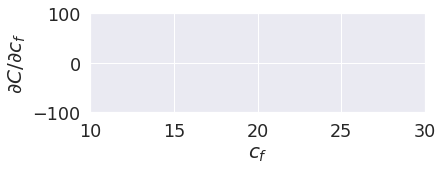

In [10]:
parameter = "c_f" # latex name of the parameter (separation radius)

plt.subplot(2, 1, 1)

dC_mean = jnp.mean(_dC_dparam, axis=1)
dC_std = jnp.std(_dC_dparam, axis=1)

plt.plot(parameter_search_space, dC_mean, linewidth=3)
plt.fill_between(parameter_search_space, dC_mean + dC_std, dC_mean - dC_std, alpha=0.4)

plt.xlim([10., 30.0])
plt.ylim([-100, 100])

plt.xlabel(f"${parameter}$", fontsize=20)
plt.ylabel(f"$\\partial C /\\partial {parameter}$", fontsize=20)

This notebook follows the procedure of [Jax-MD's Meta-Optimization Tutorial](https://github.com/google/jax-md/blob/main/notebooks/meta_optimization.ipynb).